# Comparative Analysis
In this notebook, we compare ClaSS with different competitors regarding scalability.

In [1]:
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
import numpy as np
import pandas as pd
import daproli as dp

import pandas as pd
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
sns.set_color_codes()

import gc
import Orange
import sys
sys.path.append("../")

from tqdm import tqdm
from scipy import stats

In [3]:
from src.visualizer import plot_profile, plot_profile_with_ts
from src.utils import load_combined_dataset, load_benchmark_dataset
from src.clazz.window_size import suss

Let's choose a score for evaluation (F1 or Covering).

In [6]:
eval_score = "covering_score"

In [4]:
df_comb = load_combined_dataset()
df_comb['window_size'] = df_comb.time_series.apply(lambda ts: np.int64(suss(ts[:10_000])))
df_comb['ts_len'] = df_comb.time_series.apply(len)
# takes too much space
df_comb.drop("time_series", axis=1, inplace=True)
df_comb.head()

,name,window_size,change_points,ts_len
0,Adiac,22,"[572, 1012, 1232]",1408
1,ArrowHead,32,[753],1506
2,Beef,66,[705],1410
3,BeetleFly,34,[1280],2560
4,BirdChicken,48,[1280],2560


Let's load the scores from the different methods.

In [7]:
competitors = ["ClaSS", "FLOSS", "Window"] # "BOCD", 
datasets = ["UTSA", "TSSB", "PAMAP", "mHealth", "WESAD", "MIT-BIH-VE", "MIT-BIH-Arr", "SleepDB"]
converters = dict([(column, lambda s: np.sum(eval(s))) for column in ["runtimes"]])
methods, dfs = list(), list()

for candidate_name in competitors:
    methods.append((candidate_name, f"{candidate_name}.csv"))

for idx, (name, file_name) in tqdm(enumerate(methods)):
    df = []
    
    for d in tqdm(datasets):
        tmp = pd.read_csv(f"../experiments/competitor_{d}/{file_name}.gz", usecols=["dataset", eval_score, "runtimes"], converters=converters, compression="gzip")
        tmp["name"] = d
        
        df.append(tmp)
        gc.collect()
        
    df = pd.concat(df)    
    df.sort_values(by="dataset", inplace=True)
    df.reset_index(drop=True, inplace=True)
    dfs.append((name, df))
   
df_runtimes = pd.DataFrame()
df_throughput = pd.DataFrame()
df_scores = pd.DataFrame()

for name, df in dfs:
    df_runtimes["name"] = df["name"]
    df_runtimes["dataset"] = df.dataset
    df_runtimes[name] = df.runtimes
    
    df_throughput["name"] = df["name"]
    df_throughput["dataset"] = df.dataset
    df_throughput[name] = (df_comb.ts_len / df.runtimes)

    df_scores["name"] = df["name"]
    df_scores["dataset"] = df.dataset
    df_scores[name] = df[eval_score]
    
idx_sizes = np.argsort(df_comb.ts_len).to_numpy()
df_throughput

0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [17:30<00:00, 131.25s/it]
1it [17:30, 1050.05s/it]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [17:44<00:00, 133.04s/it]
2it [35:14, 1058.46s/it]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [16:32<00:00, 124.04s/it]
3it [51:46, 1035.59s/it]


,name,dataset,ClaSS,FLOSS,Window
0,TSSB,Adiac,351.905865,49.435269,1052.930707
1,TSSB,ArrowHead,368.690219,52.287927,1067.033208
2,TSSB,Beef,369.880694,52.656364,1454.477935
3,TSSB,BeetleFly,461.281209,97.794542,1049.472804
4,TSSB,BirdChicken,438.152094,85.830837,1022.196845
5,TSSB,CBF,290.195912,33.586644,1193.495450
6,UTSA,Cane,286.507893,256.589028,1423.772196
7,TSSB,Car,435.343535,74.748514,1004.243544
8,TSSB,Chinatown,978.353920,99.038093,2223.869533
9,TSSB,ChlorineConcentration,391.811978,271.650371,1257.789637


Let's calculate the sum/mean/std score.

In [71]:
(df_runtimes.iloc[:,2:].sum(axis=0) / 60) / 60

ClaSS      479.550538
FLOSS     1637.809210
Window     137.595051
dtype: float64

In [9]:
df_throughput.mean(axis=0)

/var/folders/5_/fv_bzq1n4n76j6l_jqgndj6c0000gn/T/ipykernel_1860/2575769137.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_throughput.mean(axis=0)


ClaSS     313.556469
FLOSS     145.386672
Window    973.707163
dtype: float64

In [10]:
df_throughput.std(axis=0)

/var/folders/5_/fv_bzq1n4n76j6l_jqgndj6c0000gn/T/ipykernel_1860/676843339.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_throughput.std(axis=0)


ClaSS     110.694271
FLOSS     242.662660
Window    199.017809
dtype: float64

Let's compute the wins per method.

In [11]:
ranks = df_runtimes.rank(1, method = 'min', ascending=True)
means = np.array(ranks.mean(axis=0))

In [12]:
for mean, name in zip(means, df_runtimes.columns[2:]):
    print(f"{name}:wins={ranks[ranks[name] == 1].shape[0]} rank={np.round(mean, 5)}")

ClaSS:wins=0 rank=2.03547
FLOSS:wins=10 rank=2.94764
Window:wins=582 rank=1.01689


Let's plot and output the ranks.

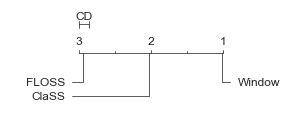

In [13]:
cd = Orange.evaluation.scoring.compute_CD(means, df_runtimes.shape[0])
Orange.evaluation.scoring.graph_ranks(means, df_runtimes.columns[2:], cd=cd, width=4, reverse=True, textspace=1, filename=f"../figures/cd_runtime.pdf")

Let's compute wins/losses against ClaSS.

In [14]:
selection = "ClaSS"

for rival in df_runtimes.columns[2:]:
    if rival == selection: continue
    
    df_pair = df_runtimes[[selection, rival]]
    pair_ranks = df_pair.rank(1, method = 'min', ascending=True)
    
    wins = pair_ranks[(pair_ranks[selection] == 1) & (pair_ranks[rival] == 2)].shape[0]
    losses = pair_ranks[(pair_ranks[selection] == 2) & (pair_ranks[rival] == 1)].shape[0]
    ties = pair_ranks[(pair_ranks[selection] == 1) & (pair_ranks[rival] == 1)].shape[0]
    
    assert wins + losses + ties == pair_ranks.shape[0]
    
    print(f"{selection} vs {rival}: (wins/ties/losses): {wins}/{ties}/{losses}")

ClaSS vs FLOSS: (wins/ties/losses): 571/0/21
ClaSS vs Window: (wins/ties/losses): 0/0/592


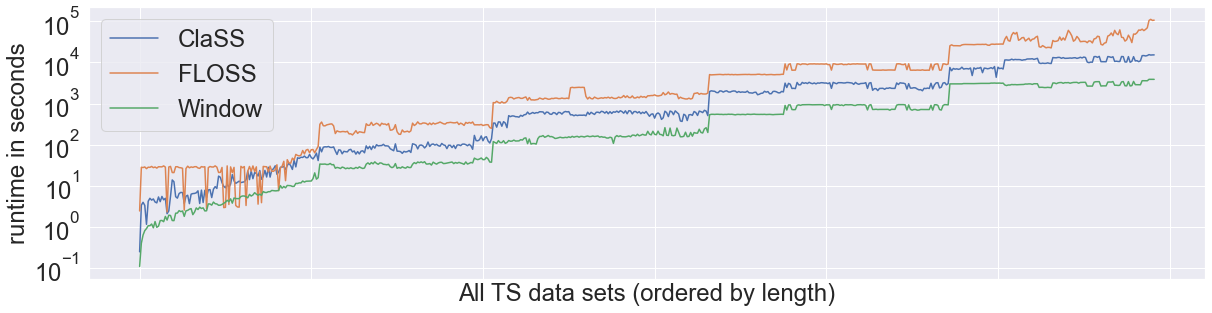

In [15]:
fontsize = 24
_, ax  = plt.subplots(1, figsize=(20,5))

for name in df_runtimes.columns[2:]:
    ax.plot(df_runtimes[name].to_numpy()[idx_sizes], label=name)
    
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)
    
ax.tick_params(
    axis='x',          
    which='both',      
    labelbottom=False,
    labelleft=False
)
ax.legend(loc=2, prop={'size': fontsize})
ax.set_xlabel("All TS data sets (ordered by length)", fontsize=fontsize)
ax.set_ylabel("runtime in seconds", fontsize=fontsize)

ax.set_yscale('log')

names = df_runtimes.name.to_numpy().tolist()      
names = np.array(names)[idx_sizes]

plt.savefig(f"../figures/runtime.pdf", bbox_inches="tight")

,ClaSS,FLOSS,Window
name,,,
MIT-BIH-Arr,4513.880310,13055.795072,1353.032306
MIT-BIH-VE,1395.505891,3728.003645,398.632337
PAMAP,1182.239189,3169.900957,339.905187
SleepDB,17801.527939,63378.063159,4463.041517
TSSB,13.104518,32.041103,4.943889
UTSA,21.201927,29.056332,5.818624
WESAD,3718.502616,14451.004110,1641.741000
mHealth,127.069900,424.688222,48.588189


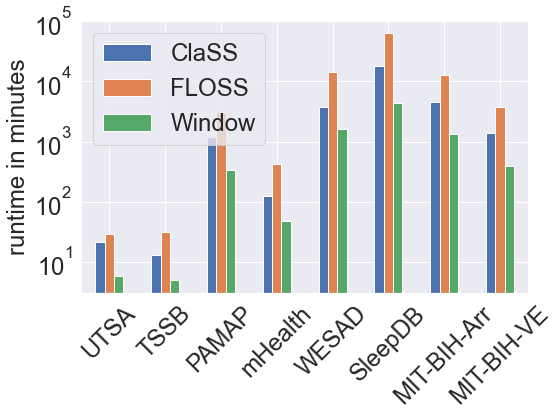

In [67]:
fontsize = 24

ax = df_runtimes.groupby("name").sum().T[['UTSA','TSSB','PAMAP','mHealth','WESAD','SleepDB','MIT-BIH-Arr','MIT-BIH-VE']].T.apply(lambda x: x / 60).plot(kind="bar", figsize=(8,5), rot=45)
    
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)


ax.set_yscale('log')

ax.legend(prop={'size': fontsize})
ax.set_xlabel("", fontsize=fontsize)
ax.set_ylabel("runtime in minutes", fontsize=fontsize)


plt.savefig(f"../figures/bar_runtime.pdf", bbox_inches="tight")

df_runtimes.groupby("name").sum() / 60

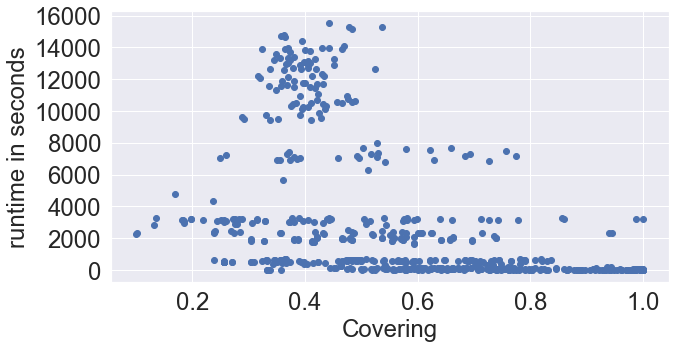

In [17]:
fontsize = 24

_, ax = plt.subplots(1, figsize=(10,5))
ax.scatter(df_scores.ClaSS, df_runtimes.ClaSS)
ax.set_xlabel("Covering", fontsize=fontsize)
ax.set_ylabel("runtime in seconds", fontsize=fontsize)

# ax.set_yscale('log')

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)

plt.savefig(f"../figures/runtime_covering.pdf", bbox_inches="tight")

In [55]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

lr = LinearRegression().fit(df_comb.ts_len.to_numpy().reshape(-1,1), df_runtimes.ClaSS.to_numpy().reshape(-1,1))
y_min, y_max = lr.predict(np.array([df_comb.ts_len.min(), df_comb.ts_len.max()]).reshape(-1,1)).flatten()

# mean deviation predicted / actual ts length
np.mean(np.abs(1 - lr.predict(df_comb.ts_len.to_numpy().reshape(-1,1)).flatten() / df_runtimes.ClaSS.to_numpy()))



# print(f"Mean absolute error: {np.round(mean_absolute_error(df_runtimes.ClaSS.to_numpy(), lr.predict(df_comb.ts_len.to_numpy().reshape(-1,1)).flatten()), 3)} seconds")

1.1770100998553221

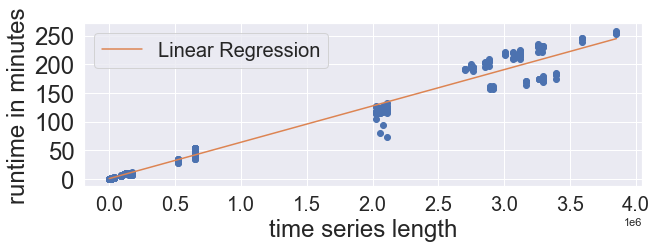

In [64]:
fontsize = 24

_, ax = plt.subplots(1, figsize=(10,3))
ax.scatter(df_comb.ts_len, df_runtimes.ClaSS / 60)

ax.plot([df_comb.ts_len.min(), df_comb.ts_len.max()], [y_min / 60, y_max / 60], c="C1", label="Linear Regression")

# ax.set_yscale('log')

ax.set_xlabel("time series length", fontsize=24)
ax.set_ylabel("runtime in minutes", fontsize=24)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)
    
ax.legend(loc=2, prop={'size': fontsize-4})

plt.savefig(f"../figures/runtime_length.pdf", bbox_inches="tight")

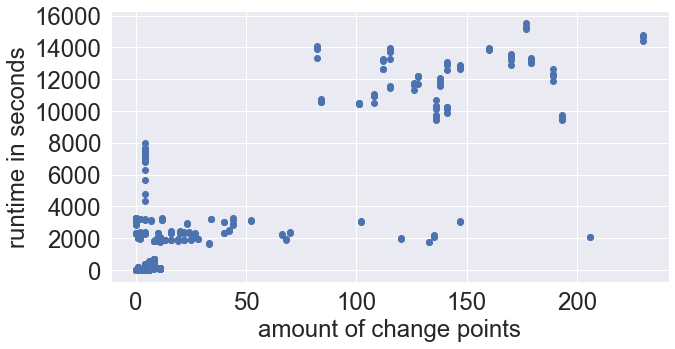

In [20]:
fontsize = 24

_, ax = plt.subplots(1, figsize=(10,5))
ax.scatter(df_comb["change_points"].apply(len), df_runtimes.ClaSS)
ax.set_xlabel("amount of change points", fontsize=24)
ax.set_ylabel("runtime in seconds", fontsize=24)

# ax.set_yscale('log')

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)

plt.savefig(f"../figures/runtime_cps.pdf", bbox_inches="tight")

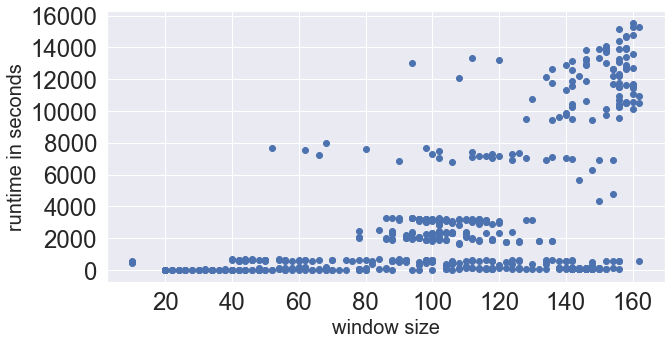

In [21]:
fontsize = 24

_, ax = plt.subplots(1, figsize=(10,5))
ax.scatter(df_comb.window_size, df_runtimes.ClaSS)
ax.set_xlabel("window size", fontsize=20)
ax.set_ylabel("runtime in seconds", fontsize=20)

# ax.set_yscale('log')

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)

plt.savefig(f"../figures/runtime_window.pdf", bbox_inches="tight")

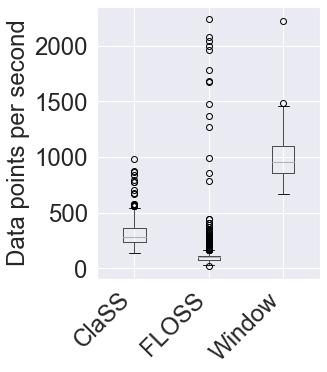

In [58]:
fontsize = 24
_, ax = plt.subplots(figsize=(4,5))

df_throughput.boxplot(ax=ax, rot=90)
ax.set_ylabel("Data points per second", fontsize=fontsize)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)
    
ax.set_xticklabels(df_scores.columns[2:], rotation=45, ha="right")
plt.savefig(f"../figures/bp_throughput.pdf", bbox_inches="tight") 